In [2]:
import pandas as pd, os 
from google.cloud import bigquery

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

### Loads newspaper articles to BQ

In [4]:
def get_bq_client(creds_file, gcloud_project):
    return bigquery.Client.from_service_account_json(creds_file, project=gcloud_project)

In [5]:
creds = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")
gcloud_project = "stock-sentiment-nlp"
bq_client = get_bq_client(creds, gcloud_project)

In [6]:
# pyarrow needs to be installed to load df to tables
news_df = {}
path = "./news_scraping/csv"
for stock in os.listdir(path):
    if os.path.isdir(f"{path}/{stock}"):
        months_df = []
        for file in os.listdir(f"{path}/{stock}"):
            month = pd.read_csv(f"{path}/{stock}/{file}", index_col = 0)
            month.date_google = pd.to_datetime(month.date_google, errors = "coerce")
            month.date_article = pd.to_datetime(month.date_article, errors = "coerce")
            months_df.append(month)
        news_df[stock] = pd.concat(months_df).drop_duplicates("title").sort_values("date_google").dropna()

<AxesSubplot:xlabel='date_google'>

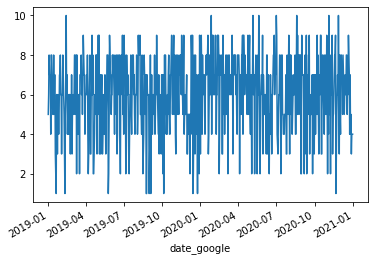

In [401]:
aapl_df.groupby("date_google").count().date_article.plot()

In [7]:
for stock, data in news_df.items():
    print(stock, data.shape)

AAPL (4350, 9)
KHC (3091, 9)
PEP (3702, 9)
GS (3727, 9)
MSFT (4152, 9)
MCD (3681, 9)
OXY (2163, 9)


In [420]:
for stock, data in news_df.items():
    data.insert(0,"id", list(map(str,data.index.values)))
    bq_client.load_table_from_dataframe(
        dataframe = data,
        destination = f"{gcloud_project}.news.{stock}_news"
    )
    print(f"Table for {stock} news created")
    

Table for AAPL news created
Table for KHC news created
Table for PEP news created
Table for GS news created
Table for MSFT news created
Table for MCD news created
Table for OXY news created


## Extract sentiment from titles

In [9]:
from transformers import pipeline, AutoTokenizer

In [12]:
nlp = pipeline("sentiment-analysis", 
               model = "nlptown/bert-base-multilingual-uncased-sentiment", 
               return_all_scores = True,
              )

In [11]:
nlp_binary = pipeline("sentiment-analysis", return_all_scores = True)

In [82]:
from dotenv import load_dotenv
load_dotenv()

True

In [501]:
for stock, data in news_df.items():
    dates = pd.DataFrame(index = pd.date_range(start = "2019-01-01", end = "2020-12-31"))
    group = data[["id","date_google"]].groupby("date_google").count()
    series = pd.merge(dates,group, right_index=True,left_index=True, how = "left")
    print(stock, series.isna().sum()["id"], series.isna().sum()["id"]/dates.shape[0])


AAPL 4 0.005471956224350205
KHC 26 0.03556771545827633
PEP 7 0.009575923392612859
GS 18 0.024623803009575923
MSFT 4 0.005471956224350205
MCD 3 0.004103967168262654
OXY 66 0.09028727770177838


In [245]:
aapl.df.filter(regex= ".*star|date").groupby("date_google").mean()

,1star,2star,3star,4star,5star
date_google,,,,,
2019-01-01,0.253788,0.128913,0.125066,0.177094,0.315139
2019-01-02,0.303710,0.265214,0.196968,0.115603,0.118505
2019-01-03,0.434582,0.226347,0.099841,0.097231,0.141997
2019-01-04,0.279709,0.317652,0.220258,0.101821,0.080560
2019-01-05,0.391620,0.209965,0.168621,0.122835,0.106959
...,...,...,...,...,...
2020-11-17,0.743428,0.168411,0.055357,0.016466,0.016338
2020-11-24,0.331210,0.282609,0.225910,0.127370,0.032901
2020-12-13,0.584953,0.234888,0.108176,0.044026,0.027957


In [ ]:
sentiment
- date
- avg sent pred 1,2,3,4,5
- close, open, etc

headlines
- date
- id
- classif (0-5)
- url
- title
- description


In [634]:
predict(target)

2509
1946


[[{'label': '1 star', 'score': 0.03626902028918266},
  {'label': '2 stars', 'score': 0.0731431096792221},
  {'label': '3 stars', 'score': 0.14485271275043488},
  {'label': '4 stars', 'score': 0.4848562479019165},
  {'label': '5 stars', 'score': 0.26087892055511475}]]

In [9]:
for stock in ["AAPL", 'KHC', 'PEP', 'GS', 'MSFT', 'MCD', 'OXY']:
    sp = SentimentPredictor(stock)
    sp.predict_title_and_description()
    sp.push_headlines_to_bq()
    sp.push_series_to_bq()
    print("STOCK COMPLETED", stock, datetime.now())
    sentiment_predictors[stock] = sp
    

/Users/juanluisrto/opt/anaconda3/envs/cloud/lib/python3.8/site-packages/google/cloud/bigquery/client.py:447: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  warnings.warn(


NameError: name 'datetime' is not defined

In [13]:
class SentimentPredictor:
    gcloud_project = "stock-sentiment-nlp"
    bq_client = get_bq_client(os.environ.get("GOOGLE_APPLICATION_CREDENTIALS"), gcloud_project)
    nlp = pipeline("sentiment-analysis", 
               model = "nlptown/bert-base-multilingual-uncased-sentiment",
               return_all_scores = True)
    
    def __init__(self,stock):
        self.stock_name = stock
        self.get_df_from_bq()
    
    def get_df_from_bq(self):
        self.df = bq_client.query(
            f"""SELECT id, date_google, title, description, url 
                FROM `{gcloud_project}.news.{self.stock_name}_news`""").result().to_dataframe()
    
    def predict(self, text):
        while(len(text) > 0):
            try:
                return self.nlp(text)
            except RuntimeError:
                text = " ".join(text.split(" ")[:-100])
        
    def predict_and_separate_stars(self,x):
        out = self.predict(x)[0]
        return out[0]["score"], out[1]["score"], out[2]["score"], out[3]["score"], out[4]["score"]
    
    def predict_title_and_description(self):
        text = self.df.title.apply(str) #+ " " + self.df.description.apply(str)
        self.df['star1'], self.df['star2'], self.df['star3'], self.df['star4'], self.df['star5'] = zip(*text.map(self.predict_and_separate_stars))
        self.df["winner"] = self.df.filter(regex = ".*star").idxmax(axis=1)
        
    
    def push_headlines_to_bq(self):
        self.headlines = self.df[["date_google", "url", "title", "description", "winner"]]
        bq_client.load_table_from_dataframe(
            dataframe = self.headlines,
            destination = f"{gcloud_project}.headlines.{self.stock_name}_titles"
            )
    def push_series_to_bq(self):
        dates = pd.DataFrame(index = pd.date_range(start = "2019-01-01", end = "2020-12-31"))
        average = self.df.filter(regex= "star.*|date").groupby("date_google").median()
        average.index = average.index.tz_localize(None)
        self.series = pd.merge(dates,average, right_index=True,left_index=True, how = "left").reset_index()
        bq_client.load_table_from_dataframe(
            dataframe = self.series,
            destination = f"{gcloud_project}.series.{self.stock_name}_series_titles_median"
            )
        
        
        
        
        
        
        